### Name: Yulin Zhuo 
### Github username: edsml-yz6622

# Dataset Loading and Analysis

In this notebook, we will ustilise the `sweDataset.py` to load and prepare data for training.

# Import packages

In [1]:
# Import 
import sys
sys.path.append("./swe_tool")

from swe_tool.sweDataset import sweDataset
import pandas as pd
from swe_tool import tool
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load data and define variables

In [2]:
folder_path = './dataset/'

In [3]:
# Define variables
train_file_path = folder_path + 'train_updated_sc.csv'
test_file_path = folder_path + 'test_updated_sc.csv'
var = ['HS', 'temperature', 'precipitation', 'snowfall', 'solar_radiation']
ts = 30 

# Read data
df = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)

# Data pre-process

In [4]:
# # If wants to apply perturbation into snow depth according to WMO’s guidelines
# df['HS'] = df['HS'].apply(tool.apply_perturbation)
# df['HS'][df['HS'] <= 0] = 0

# Initialisation

In [5]:
# Initialise
dataset = sweDataset(df=None, df_test=None, train_file=train_file_path, test_file=test_file_path, var=var, ts=30)
# or
# dataset = sweDataset(df=df, df_test=df_test, train_file=None, test_file=None, var=var, ts=30)

# Data overview

In [6]:
# Display the first few rows of the training set
print(dataset.df.head())

         date        HS  station_SWE      loc  precipitation  snowfall  \
0  2012-01-01  0.080978     0.041168  US_ab39       0.000177  0.000124   
1  2012-01-02  0.080978     0.041168  US_ab39       0.000000  0.000000   
2  2012-01-03  0.082777     0.041168  US_ab39       0.000177  0.000144   
3  2012-01-04  0.088176     0.045285  US_ab39       0.005923  0.005913   
4  2012-01-05  0.098973     0.049402  US_ab39       0.002917  0.002885   

   solar_radiation  temperature  snow_class  
0         0.042367    -1.106166           2  
1         0.047003    -1.119532           2  
2         0.040942    -0.981499           2  
3         0.030459    -1.218525           2  
4         0.031820    -1.386865           2  


In [7]:
# Display the statistical analysis of the training set
dataset.df.describe()

,HS,station_SWE,precipitation,snowfall,solar_radiation,temperature,snow_class
count,35810.000000,35810.000000,35810.000000,3.581000e+04,35810.000000,3.581000e+04,35810.000000
mean,0.108509,0.084732,0.036062,2.237270e-02,0.188997,5.079557e-17,3.471628
std,0.149823,0.138604,0.083299,6.732763e-02,0.239774,1.000014e+00,1.885565
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-3.444931e+00,1.000000
25%,0.000630,0.000056,0.000018,0.000000e+00,0.018428,-6.575159e-01,2.000000
50%,0.041389,0.024701,0.003000,7.327446e-08,0.088056,-1.246509e-01,3.000000
75%,0.156324,0.099972,0.031150,8.650416e-03,0.266226,5.746752e-01,5.000000
max,1.000000,1.000000,1.000000,1.000000e+00,1.000000,3.580497e+00,6.000000


# Getting data for training

In [8]:
# Get the training, validation and testing data
X_train, y_train = dataset.X_train, dataset.y_train
X_val, y_val = dataset.X_val, dataset.y_val
X_test, y_test = dataset.X_test, dataset.y_test

In [9]:
# Print the shape of X_train
X_train.shape

(23169, 30, 5)

In [10]:
# Get dataloader for training
train_loader, val_loader, test_loader = dataset.get_data_loaders()

# Data Visualisation

Data distribution

In [11]:
def rebuild_data_with_date(df, var, ts=30):
    """
    Rebuild the input data into the required shape of LSTM.

    The input data should contain the following columns (Col names should be the same.):
    - 'loc': Identifying the location.
    - 'date': The timestamp associated with each sample.
    - 'station_SWE': The target values for estimating.

    :param df: The input data needed to rebuild.
    :type df: dataframe
    :param var: The features selected in rebuilding.
    :type var: list
    :param ts: The time sequence length, the number of time steps to be considered in model, default is 30.
    :type ts: int, optinal

    :return: (input_values(np.ndarray), target_values(dataframe)): The tuple of input_values(X) and target_values(Y).
    :rtype: tuple
    """
    input_values = []
    target_values = []

    for location in df['loc'].unique():
        # Select the current location only
        loc_df = df[df['loc'] == location]  
        loc_df['date'] = pd.to_datetime(loc_df['date'])
        # Sort the data
        loc_df = loc_df.sort_values('date')  
        # Reset the index
        loc_df.reset_index(drop=True, inplace=True)  

        # Find the time gap
        time_gaps = loc_df['date'].diff() > pd.Timedelta(1, 'D')
        time_gaps = time_gaps[time_gaps].index.tolist()

        start = 0
        if time_gaps != []:
            for end in time_gaps:
                # Subtract ts from end so that i+ts will not go out of bounds
                for i in range(start, end - ts):
                    if not np.isnan(loc_df['station_SWE'][i+ts]) and all([not np.isnan(loc_df[v][i:i+ts]).any() for v in var]):
                        if not (loc_df[var][i:i+ts].sum(axis=0) == 0).all() or np.random.rand() < 0.5:
                            input_values.append({"date": loc_df['date'][i+ts], "HS": loc_df['HS'][i+ts]})
                            target_values.append({"date": loc_df['date'][i+ts], "station_SWE": loc_df['station_SWE'][i+ts]})
                start = end + 1

        # Last continuous time series
        if len(loc_df) - start >= ts: 
            for i in range(start, len(loc_df) - ts):
                if not np.isnan(loc_df['station_SWE'][i+ts]) and all([not np.isnan(loc_df[v][i:i+ts]).any() for v in var]): 
                    if not (loc_df[var][i:i+ts].sum(axis=0) == 0).all() or np.random.rand() < 0.5:
                        input_values.append({"date": loc_df['date'][i+ts], "HS": loc_df['HS'][i+ts]})
                        target_values.append({"date": loc_df['date'][i+ts], "station_SWE": loc_df['station_SWE'][i+ts]})

    input_values = pd.DataFrame(input_values)
    target_values = pd.DataFrame(target_values)
    
    return input_values, target_values

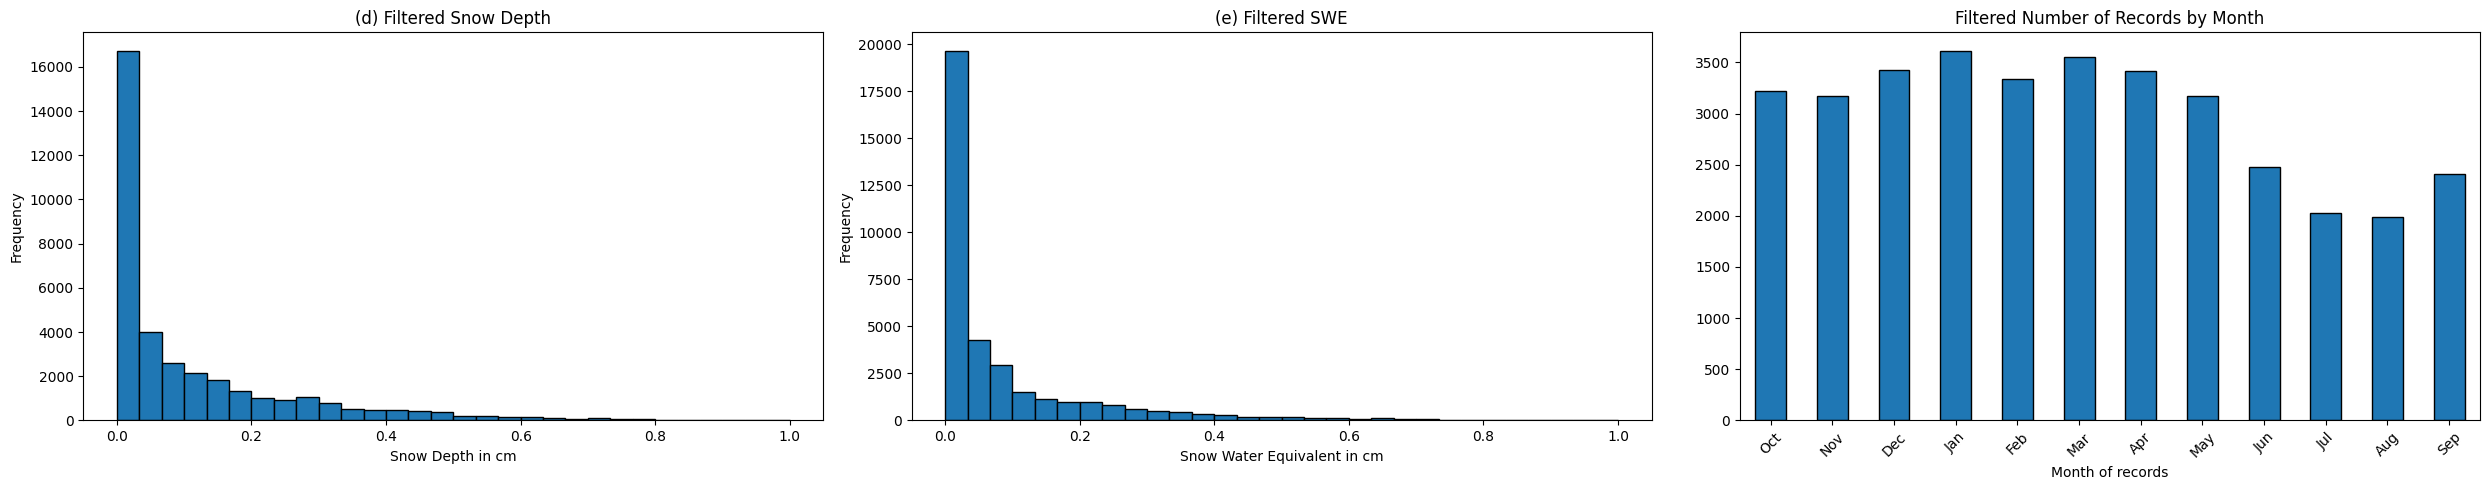

In [12]:
tool.plot_data_distribution(dataset.df[['date', 'HS']], dataset.df[['date', 'station_SWE']])

In [13]:
input_data, target_data = rebuild_data_with_date(dataset.df, ['HS'], ts=30)

/var/folders/5m/bhjjh_l15ng7p2l7swm_bkzh0000gp/T/ipykernel_44739/1749954298.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['date'] = pd.to_datetime(loc_df['date'])
/var/folders/5m/bhjjh_l15ng7p2l7swm_bkzh0000gp/T/ipykernel_44739/1749954298.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['date'] = pd.to_datetime(loc_df['date'])
/var/folders/5m/bhjjh_l15ng7p2l7swm_bkzh0000gp/T/ipykernel_44739/1749954298.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

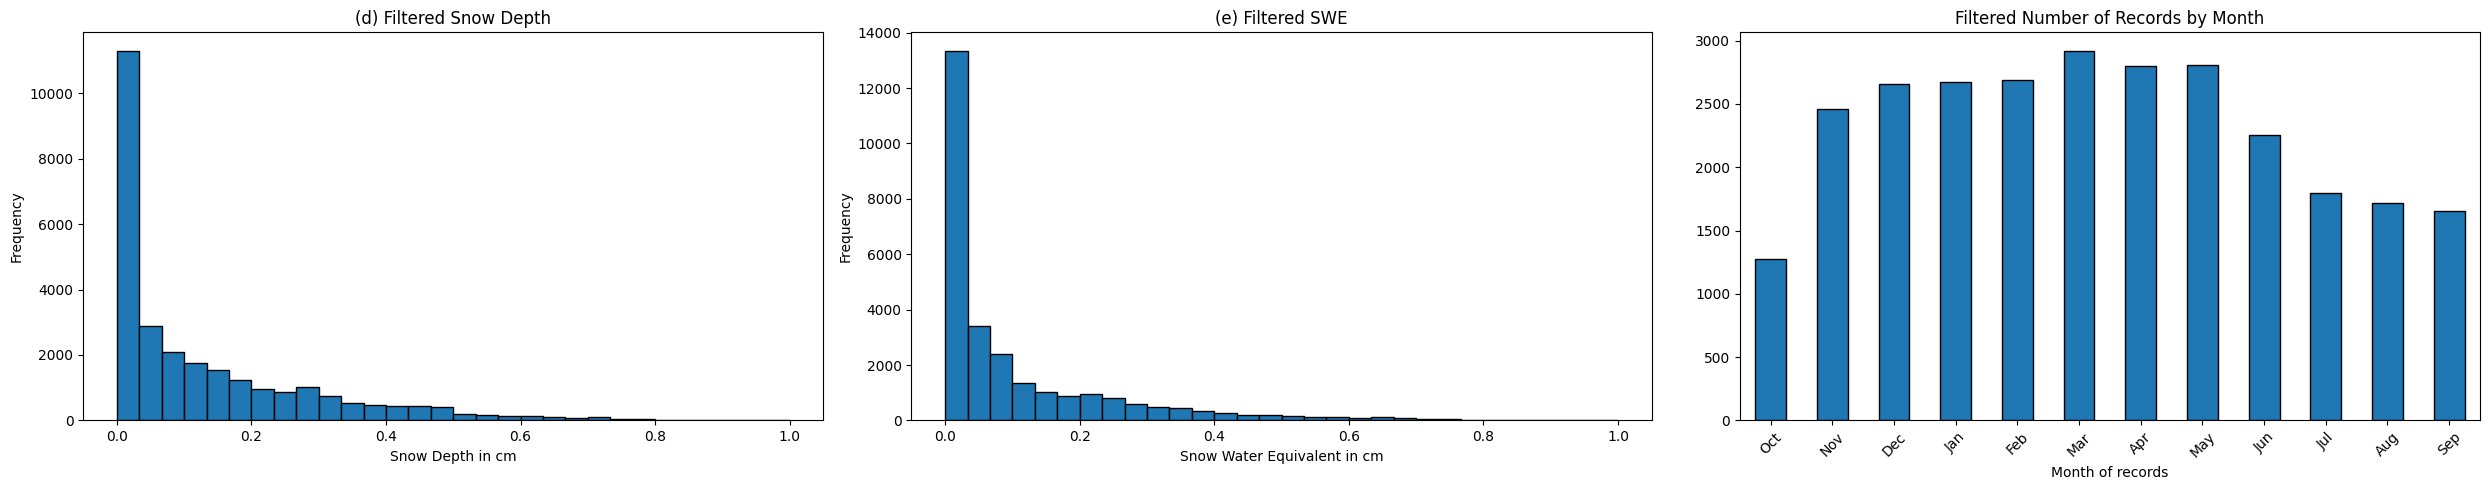

In [14]:
tool.plot_data_distribution(input_data, target_data)

## Visualisation of Distributions

/opt/homebrew/Caskroom/miniconda/base/envs/swe_est/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/swe_est/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/swe_est/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/swe_est/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_c

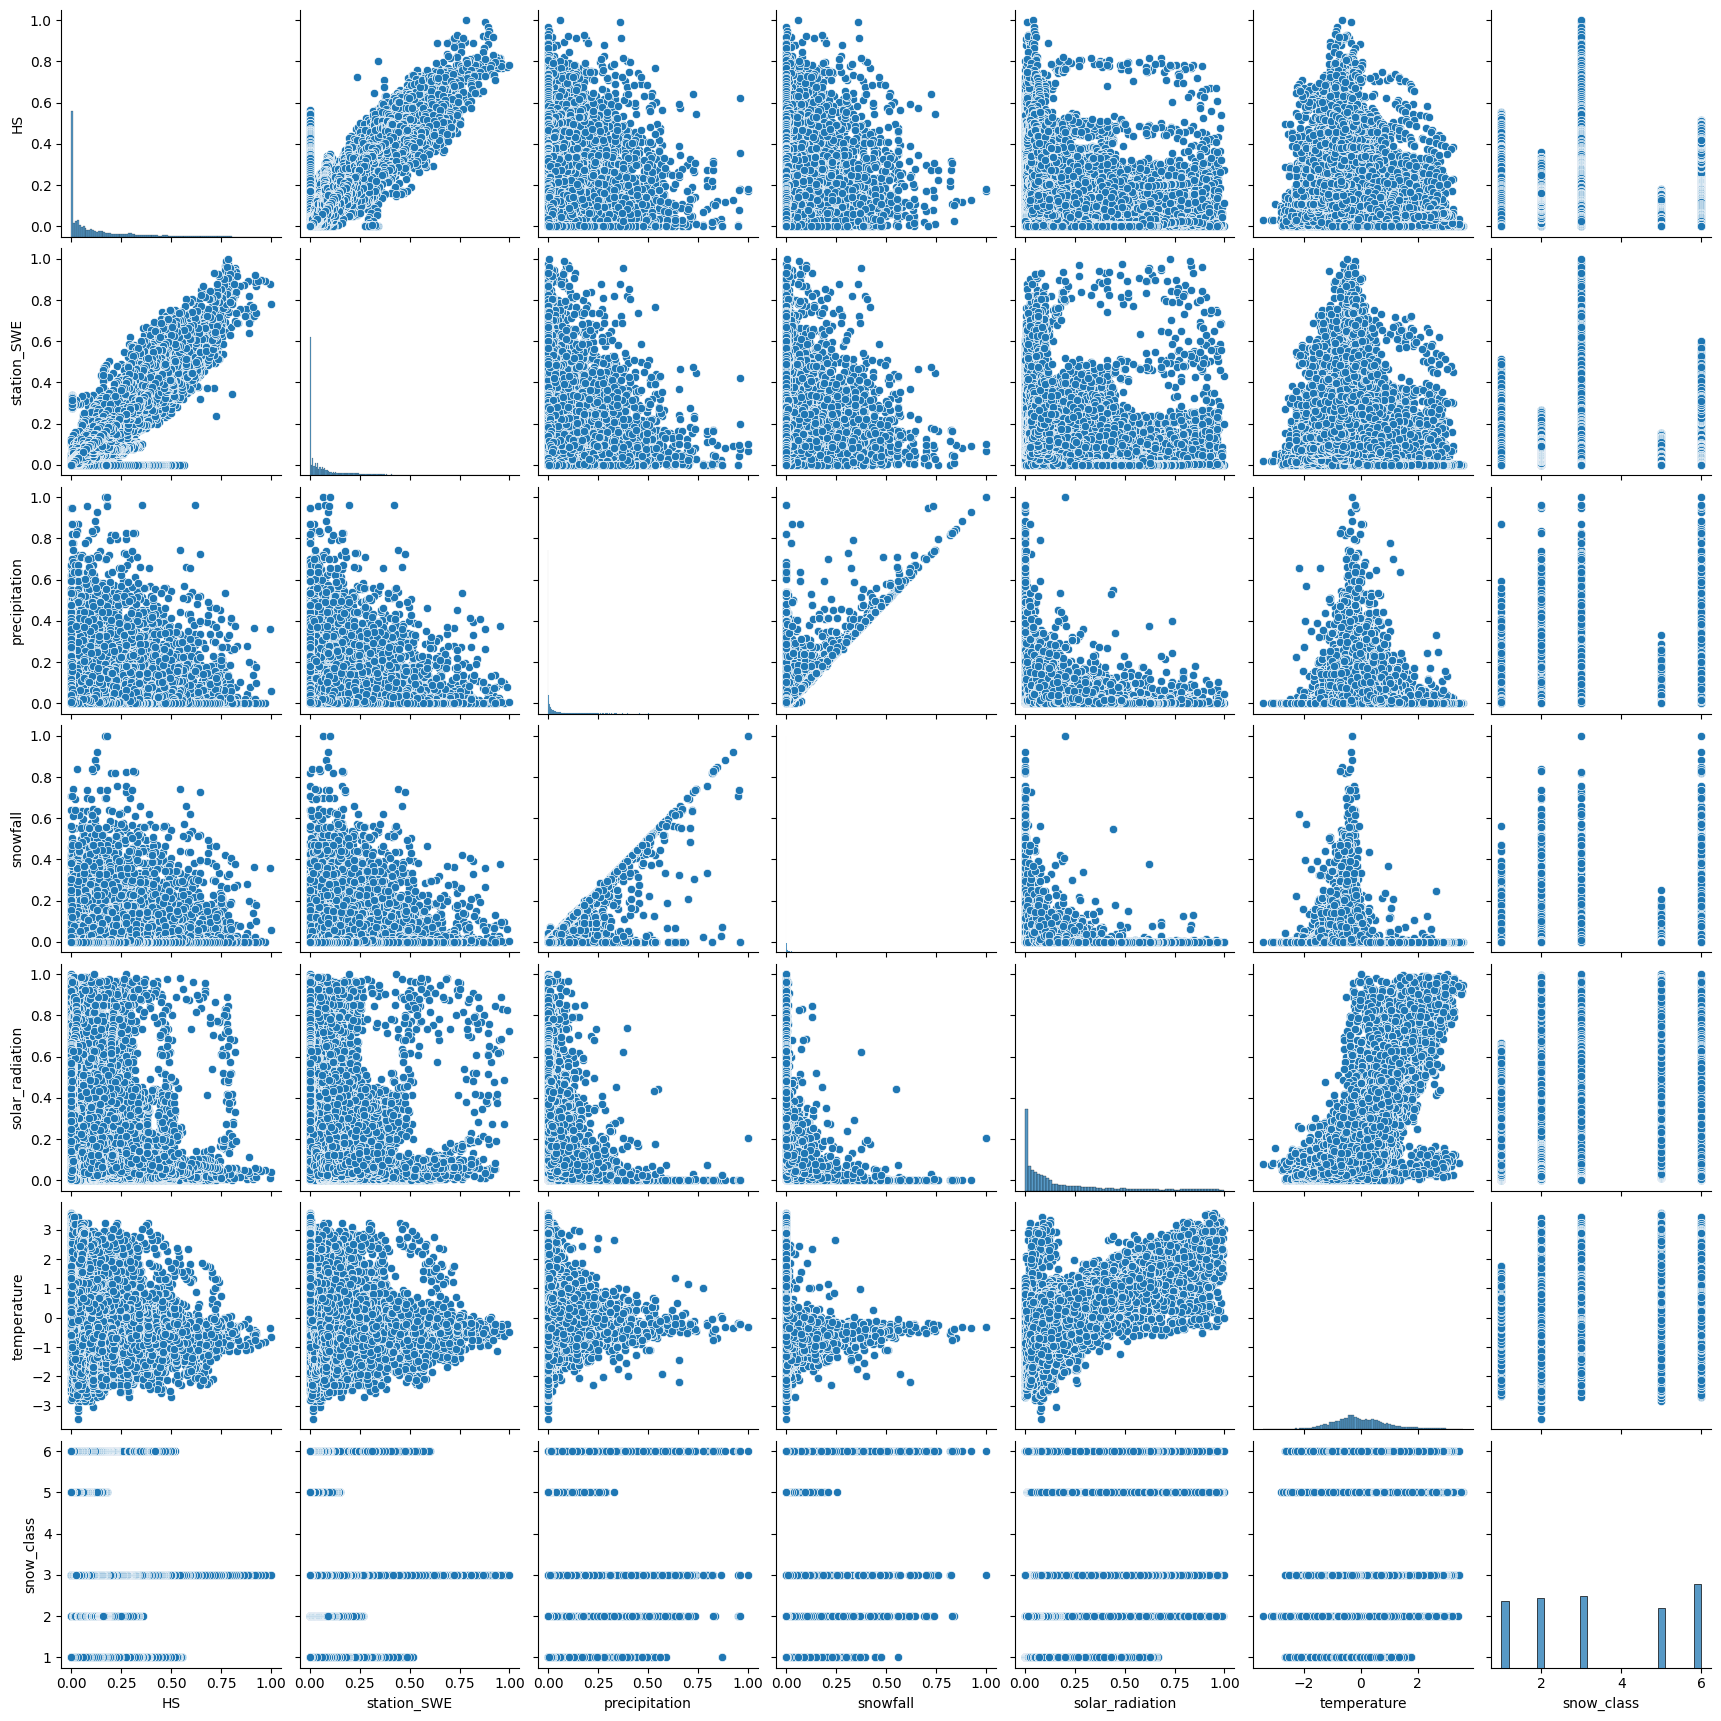

In [15]:
sns.pairplot(dataset.df)
plt.show()

## Features Correlations

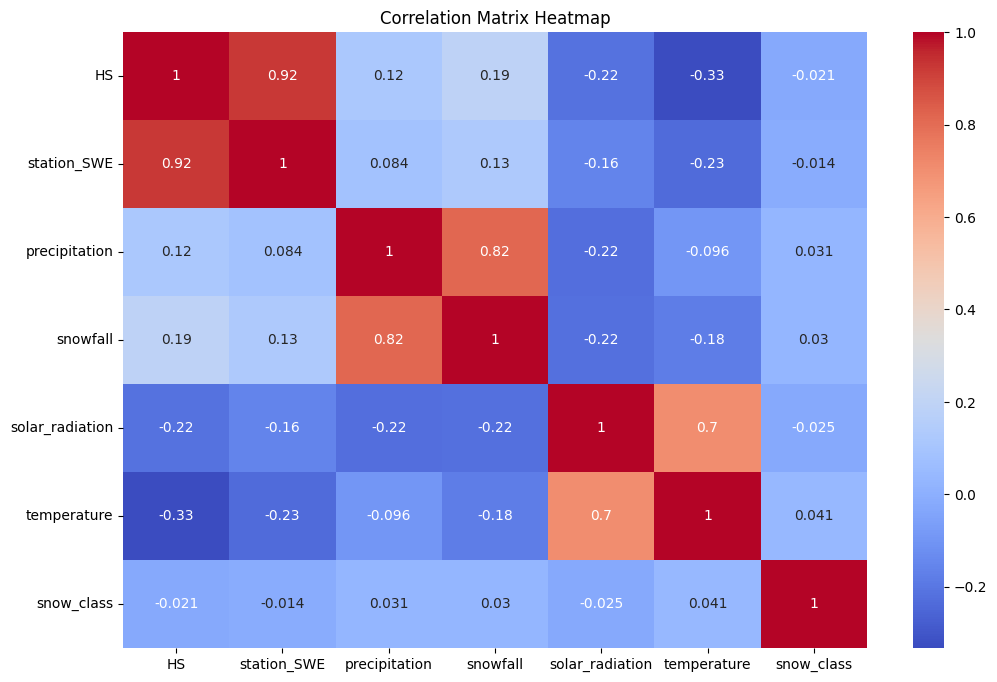

In [16]:
correlation_matrix = dataset.df.select_dtypes(include=['number']).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

## Snow Classificiation

Show the global snow classification map.

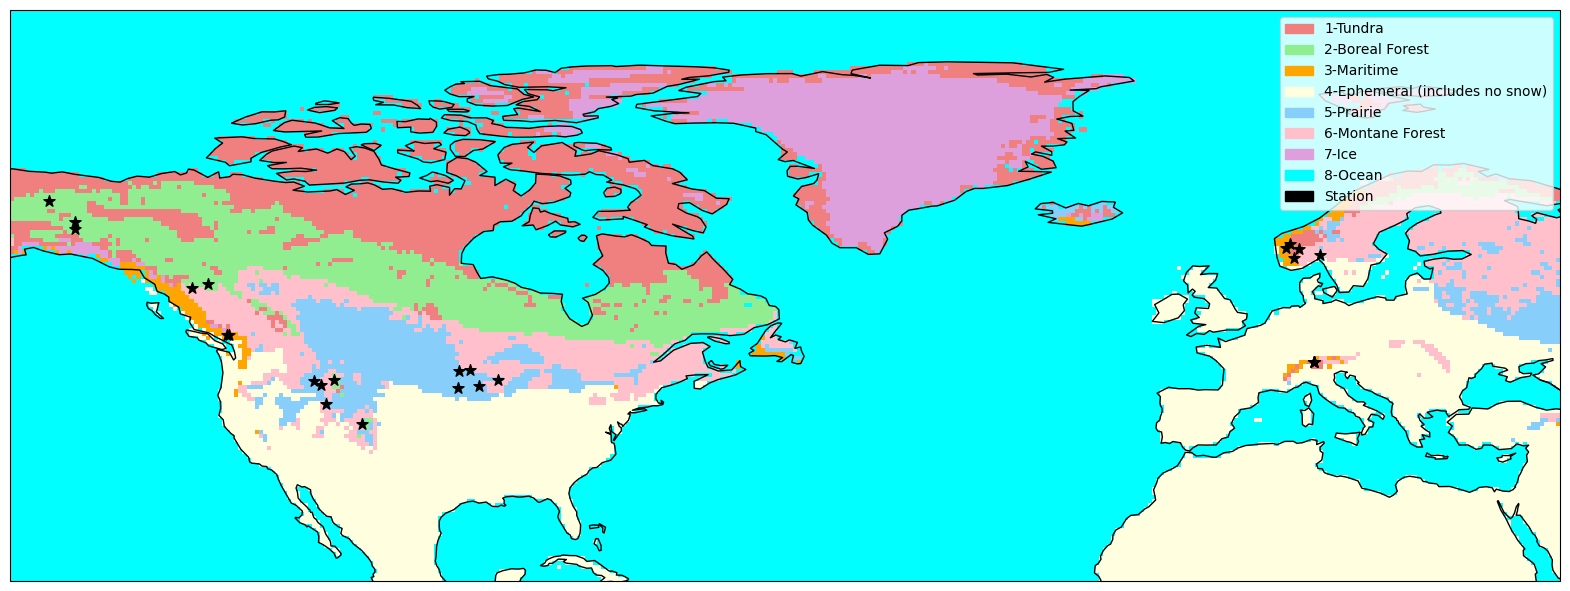

In [17]:
tool.plot_snow_class(path = './dataset/SnowClass_GL_50km_0.50degree_2021_v01.0.tif', stations_csv='./dataset/stations_loc.csv')